<a href="https://colab.research.google.com/github/devontyr/Copy-Paste/blob/main/Rads_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Train Doc2Vec**

In [ ]:
#train encoding Doc2Vec model

import gensim #well-established library
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim.downloader as api

dataset = api.load("text8") #use text8 as corpus to train the Doc2Vec model
data = [i for i in dataset]

#tag the text data
def tagged_document(list_of_sentences):
   for i, list_of_words in enumerate(list_of_sentences):
      yield TaggedDocument(list_of_words, [i]) #index is the tag

#use tagged text data
training_data = list(tagged_document(data))
model = Doc2Vec(vector_size = 20, alpha=0.025, min_alpha=0.00025, min_count = 2, epochs = 5)
'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''

model.build_vocab(training_data) #build the model vocabulary
model.train(training_data, total_examples=model.corpus_count, epochs=model.epochs) #train the model
model.save("d2v.model") #save this model
print("Model Saved")

[==================================================] 100.0% 31.6/31.6MB downloaded
Model Saved


## **Encode Words**

In [ ]:
#Run this if first time:
#from google.colab import drive
#drive.mount('/content/drive')

#Run this if uploading new files:
from google.colab import files
uploaded = files.upload()

In [ ]:
#Load data: open a file and return a list of all the sentences

import pandas as pd
import io
import os

#upload file from google drive
def open_file(name):
  file_path = '/content/' + name
  with io.open(file_path, 'r') as f:
    text = f.read()
    sentences = text.lower()
    table2 = str.maketrans('!', '.')
    table3 = str.maketrans('\n', ' ')
    sentences = sentences.translate(table2) #get rid of exclamation points
    sentences = sentences.translate(table3) #get rid of new lines
    sentences = sentences.split(".") #split string at periods
  return(sentences) #now a list

In [ ]:
#Transform data: tokenize the list of sentences

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def tokenize(sentences):
  tokenized_sentences = []
  for sentence in sentences:
      tokenized_sentences.append(word_tokenize(sentence))
  return(tokenized_sentences)

In [ ]:
#Encode our own sentences! (that do not exist in the trained model)
#From any given paragraph: create a dictionary of key, encoded arrays

from gensim.models.doc2vec import Doc2Vec
from nltk.tokenize import word_tokenize

model= Doc2Vec.load("d2v.model")

def encode_doc(paragraph):
  data = tokenize(paragraph)

  encodings_with_keys = {} #dictionary of sentence, corresponding vector
  i = 0
  for sentence in data:
    encodings_with_keys[paragraph[i]] = model.infer_vector(sentence) #the vectorized form of the test sentence

    i += 1

  return encodings_with_keys

In [ ]:
def normalize(encodings_with_keys):

  #turn the list of dictionaries into a matrix
  all_vectors = np.array(list(encodings_with_keys.values()))

  #normalize the vectors with mean and standard deviation
  print(all_vectors.std(axis=0))
  mean = all_vectors.mean(axis=0)
  std = all_vectors.std(axis=0)

  new = (all_vectors - mean) / std

  n = new.shape[0]
  for i in range(n):
    normalized_sentence_embedding = new[i,:]

  new_encoded_dict = {}
  for idx, key in enumerate(encodings_with_keys):
    new_encoded_dict[key] = new[idx,:] #new dictionary has the normalized vectors

  return new_encoded_dict, mean, std

## **LSH Scheme**

In [ ]:
import numpy as np
import math

def gen_random(r, real_vector, seed):
  """
   Args:
    r: band size, number of random vectors to be created
    real_vector: array of 0s and 1s that contains the sentence we want to hash
    seed: seed for the hash function

  Returns:
    random_vector: a vector of r random vectors all sized at the length of the sentence being hashed
  """
  np.random.seed(seed) #seed makes randomness the same

  random_vector = []
  for i in range(r):
    real_vector_len = len(real_vector)
    random_vector.append(np.random.normal(size = real_vector_len ))

  return random_vector

In [ ]:
def vector_signs(r, real_vector, random_vector):
  """
  Args:
    r: band size, number of random vectors created
    real_vector: sentence to hash
    random_vector: random seeded vector

  Returns:
    signs: a list of the signs between real_vector and random_vector
  """

  signs = ""
  for i in range(r):
    inner_product = np.dot(real_vector, random_vector[i])
    signs += str(np.sign(inner_product))
  return signs

In [ ]:
import hashlib

def hashing(signs, seed, m):
  """
  Args:
    signs: string object to hash
    seed: seed for the hash function (should be the index to the table)
    m: upper bound of the hash value (inclusive)

  Returns:
    The intended index of that sentence in the dictionary
  """

  hash_object = hashlib.sha256(str(seed).encode('utf-8')) #create a hash object with the specified seed
  hash_object.update(signs.encode('utf-8')) #update the hash object with the tuple string

  hash_value = hash_object.hexdigest() #get hash value as a hexadecimal string
  hash_value_int = int(hash_value, 16) #convert hexadecimal string to int
  return hash_value_int % m + 1 #return the hash value modulo m

In [ ]:
def create_table(m):
  table= {}
  for i in range(m):
    table[i] = []
  return table

## **PreProcess Harry Potter Texts as Corpus**

In [ ]:
def preprocessing(r, real_vector, m, t):
  '''
  Args:
    real_vector: the first paragraph to put into the table
    seed: to control the randomness
    m: the number of slots in our table
    index_list: empty list that will store the indicies of the hashed vector
  '''
  #tables = create_table(m, t) # creates t empty tables with keys 1,..,m
  new_tables = []
  #seed= 0
  for j in range(t):
    seed = j
    #active_table = tables[j]
    active_table = create_table(m)
    for i in range(len(real_vector)): # for the amount of sentences in the paragraph

      g = gen_random(r,real_vector[i], seed) # generates a random vector of r random vectors
      #returns array

      sign_x = vector_signs(r, real_vector[i], g) # compute the sign of the sentence with g r times
      #returns string

      index_xg = hashing(sign_x, seed, m) - 1 # hash that value to an index
      #returns int

      active_table[index_xg].append(i)

    new_tables.append(active_table)

  return new_tables

In [ ]:
#Harry Potter Book 1 PreProcessing!!

HPsentences = open_file('HP1.txt')
HPencoded_dict = encode_doc(HPsentences) #dictionary
new_HPecocded_dict, mean, std = normalize(HPencoded_dict) #normalized dictionary
HPvectors = list(new_HPecocded_dict.values()) #a list

m = 50000
t = 50
r = 18
HPindicies = []

## **Check a New Sentence Against the Corpus**

In [ ]:
import numpy as np
import random

def one_sentence(r, tables, t, sentence, m):
  """
  Args:
    r: the number of random vectors created
    real_vector: a list of vectors where each vector is a sentence
    t: number of hash tables/different hash functions
    real_vector2: a list of vectors where each vector is a sentence
    m: length of table
  Returns:
    similar_sentences: a list of lists of similar vectors between pargraphs 1 and 2
  """

  results = []
  for j in range(t): # will run code for t different tables
    table = tables[j]
    seed = j

    g = gen_random(r, sentence[0], seed)

    sign_y = vector_signs(r, sentence[0], g)

    index_yg = (hashing(sign_y, seed, m )) - 1 # hashes the inner products of x and g
    if table[index_yg] != []:
      results.append(table[index_yg])

  return(results)

In [ ]:
test_sentence = ["The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it."]
test_encoded_dict = encode_doc(test_sentence) #dictionary size 1

vector_to_normalize = np.array(list(test_encoded_dict.values())) #dictionary to list
new = (vector_to_normalize - mean) / std #normalize that list
normal_test_encoded_dict = {}
normal_test_encoded_dict[0] = new[0]

test_vector = list(normal_test_encoded_dict.values()) #a list size 1

## **Translate Vectors Back to Sentences**

In [ ]:
def back_to_words(results, corpus_dictionary):
  similar_sentences = []
  for table in results: #loop through the list of matching vectors
    for index in table:
      sentence = list(corpus_dictionary.keys())[index] #find the sentence that it matches in the dictionary
      if sentence not in similar_sentences:
        similar_sentences.append(sentence)
  return(similar_sentences)

## **Analyze Results**

In [ ]:
#Create t and r

import math

def prob_y(cos_theta, r, t):
  theta = math.acos(cos_theta)
  return 1 - (1- (1-theta/math.pi)**r)**t

def calc_r(cos_theta, t, success_prob):
  theta = math.acos(cos_theta)
  r = math.log(1-(1-success_prob)**(1/t)) / math.log(1 - theta/math.pi)
  return math.floor(r) # round down to integer (can only increase probability)


def t_and_r():
  for t in range(1, 1000):
    tot = 0
    r = calc_r(.75, t, .9)
    pr_find_y2 = prob_y(.5, r, t)
    if pr_find_y2  <= .1:
      break
  print("the optimal t is", t)
  print("the optimal r is", r)
  return t, r

In [ ]:
#Calculate cosine similarities

def long_way(real_vector, sentence):
  similar = []
  max_sim = 0
  index_of_max = 0
  #print("real vector", real_vector)
  #print("sentence", sentence)
  #print(similar)
  for i in range(len(real_vector)):
    cos_theta = float(np.inner(real_vector[i], sentence) / ((np.linalg.norm(real_vector[i]))*(np.linalg.norm(sentence))))
    #print(cos_theta)
    similar.append(cos_theta)
    #print(similar)
    #if max_sim < cos_theta:
      #max_sim = cos_theta
      #index_of_max = i
  #print(max_sim)
  #print(index_of_max)

  return similar #, index_of_max


similarities = long_way(HPvectors, test_vector)
print(similarities)

#the_sentence = list(HPencoded_dict.keys())[index_of_max]
#print(the_sentence)


[-0.1831841915845871, -0.4276425838470459, -0.10054722428321838, 0.2621990740299225, -0.6773437261581421, 0.11630475521087646, 0.43070298433303833, -0.5196211338043213, 0.5091657042503357, -0.505128800868988, 0.7033708095550537, 0.15005028247833252, -0.5251654386520386, 0.026697572320699692, 0.5877835750579834, -0.31164318323135376, 0.15034766495227814, 0.53639817237854, -0.39656615257263184, 0.5145224332809448, -0.6379030346870422, 0.2727477252483368, 0.0033856185618788004, -0.024996064603328705, -0.4192502796649933, 0.269378125667572, 0.3525236248970032, -0.3290316164493561, -0.5638015270233154, -0.06682150810956955, -0.2958858013153076, -0.4434850215911865, 0.4873946011066437, -0.5389115810394287, 0.4638471305370331, -0.3147636950016022, -0.5003305077552795, -0.6152061223983765, 0.3657013773918152, 0.42950665950775146, 0.5289071202278137, -0.0630432739853859, 0.5919917821884155, 0.1767546683549881, -0.6977032423019409, 0.44031471014022827, 0.13917528092861176, 0.29944920539855957, -

In [ ]:
#Histgoram

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def print_histogram(similarities):
  data = similarities

  # Plotting a basic histogram
  plt.hist(data, bins=30, color='skyblue', edgecolor='black')

  # Adding labels and title
  plt.xlabel('Cosine Similarity')
  plt.ylabel('Frequency')
  plt.title('Histogram: How Many Other Sentences are Similar to the Sentence') #add user_input at the end of this

  # Display the plot
  plot = plt.show()
  return plot

## **Main**

In [ ]:
#Sentence and Cosine Similarity
#Given one sentence, output all the similar sentences and their respective cosine simialrity with that one sentence

def find_similar_sentences():
  user_input = input("What sentence would you like to check?")

  #THIS PART DOESN'T WORK. Can't figure out how to return vector as the proper array type

  #check if sentence already exists as an encoding
  #if user_input in new_HPecocded_dict:
    #vector = (list(new_HPecocded_dict[user_input]))
    #print("TRUE")
    #print(new_HPecocded_dict)
    #print(len(vector))
    #print(vector)

  #else: #user input to normalized vector
  encoded_dict = encode_doc(user_input)

  vector_to_normalize = np.array(list(encoded_dict.values())) #dictionary to list
  new = (vector_to_normalize - mean) / std #normalize that list
  normal_encoded_dict = {}
  normal_encoded_dict[0] = new[0]

  vector = list(normal_encoded_dict.values()) #a list size 1


  #check for similarity
  t, r = t_and_r()
  t = t - 700
  m = 50000
  tables = preprocessing(r, HPvectors, m, t)


  similar_sentences = one_sentence(r, tables, t, vector, m) #??

  #turn similar vectors into sentences
  sentences = back_to_words(similar_sentences, HPencoded_dict)


  print("Given your sentence:", user_input, "the similar sentences found in Harry Potter are:")
  most_similar_sentence_int = 0
  most_similar_sentence= ''

  similarities = long_way(HPvectors, vector)

  for i in range(len(sentences)):
    if len(sentences[i]) > 48: #only want average length sentences or above!
      print(sentences[i])
      list_of_words = list(HPencoded_dict.keys())
      index = list_of_words.index(sentences[i])

      if similarities[index] > most_similar_sentence_int:
        most_similar_sentence_int = similarities[index]
        most_similar_sentence = sentences[i]
      print("cosine similarity for this sentence is:", similarities[index], "\n") #TODO!!!!!!!!!

  print("The Most Similar Sentence is: ", most_similar_sentence)
  print_histogram(similarities)
  print("That's it!")

What sentence would you like to check? harry grabbed dumbledor and screamed in his face
the optimal t is 724
the optimal r is 22
Given your sentence:  harry grabbed dumbledor and screamed in his face the similar sentences found in Harry Potter are:
  "why would you be mad to try and rob gringotts?" harry asked
cosine similarity for this sentence is: 0.47286510467529297 

 i think they should keep it in the old wizarding families
cosine similarity for this sentence is: 0.5187848806381226 

 he must have had to bunny hop all the way up to gryffindor tower
cosine similarity for this sentence is: 0.6820193529129028 

"  it seemed to be a handsome, leather-covered book
cosine similarity for this sentence is: 0.5907096862792969 

 next door's problems with her daughter and how dudley had learned a new word ("won't
cosine similarity for this sentence is: 0.5043522119522095 

" hissed professor mcgonagall, "you'll wake the muggles
cosine similarity for this sentence is: 0.6225220561027527 

  

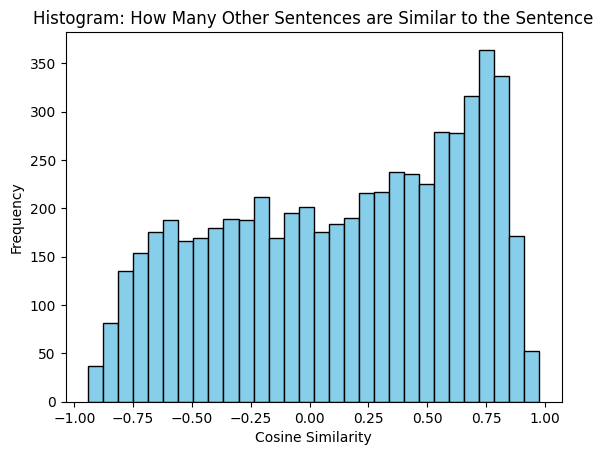

That's it!


In [ ]:
find_similar_sentences()